Outline of simulations:
- generate all possible resource preference lists
    
- generate growth rates for each resource for each species (draw them from a normal distribution, to avoid super-bug and extreme specialists)
- pick resource concentrations (start with equal case 1:1, then test 2:1 etc.)
- perform species invasions from the pool until the uninvadable state is reached via dynamic simulations
- keep track of invasion events, so we'll be able to plot diversity w/ time, complementarity w/ time, etc.

How to do serial dilution computation - perform stepwise estimation for resource usage:
- start with $B_0$ and $C_0$, get equations for each resource, solve for T
- compare T of resource depletion
- pick the smallest time, switch resources
- update bacterial abundances and resource concentrations
- continue until end of dilution cycle reached/all resources depleted
- every bacteria, with population below the threshold (e.g. $10^{-5}$) is doomed to be extinct
- the steady state should be reached in 5-10 dilution cycles
- make sure that any leftovers of the resources, that are unused by the end of the cycle are added to the new one with the same dilution factor as bacterial abundances (it's important for the low dilution case)

List of questions
- what is the optimal diauxic strategy?
- we expect to get a set of microbes with a complementary growth strategies in the end. Is it true?
- is it true that unequal resource supply will change the winning strategy?

Problem
- We may not find every uninvadable state in this fashion. Given a pool it could only find one. 


In [2]:
# initialization

import numpy as np
import math
import random
import itertools
from scipy.optimize import root
import copy
import time
# set resource number and amount
Nr = 3
Res = [1.0, 1.0, 1.0]

# generate species pool: growth rate from gaussian; preference list; invasion order
# growth rates
Size = 20 # number of samples from each species
Nb = math.factorial(Nr)*Size
g_mean, g_var = 1, 0.2
growth_rate_list = np.exp(np.random.normal(g_mean, math.sqrt(g_var), (Nb, Nr)))
filt = np.heaviside(growth_rate_list, 0)
growth_rate_list = filt*growth_rate_list
#preference list
preference_list = list(itertools.permutations(range(Nr), Nr))
b0 = 1e-3 # density of bug when introduced/initial
b_threshold = 1e-6 # extinction density
c_threshold = 1e-9 # concentration threshold
# invasion order
invasion_list = list(range(Nb))
random.shuffle(invasion_list)
# yields
yields_list = 0.5*np.ones([Nb, Nr]) # might need to be modified later?

# dilution parameters 
D = 1e-3
tau = 0 # lag
T_dilute = 10 # time interval between dilutions
dilute_to_steady = 10 # #(dilution) between invasions

In [3]:
def dilute(system): 
    global t_system
    t_switch = 0
    while t_switch < T_dilute:
        #list of resource in use for each consumer
        use = [0 for i in range(Nb)]
        # list of consumers for each resource
        consumer = [[] for i in range(Nr)]
        for i in range(Nb):
            # if all are depleted, bug still uses its least preferred nutrient
            while system['res_available'][preference_list[i//Size][use[i]]] < 1 and use[i] < Nr - 1:
                use[i] = use[i] + 1
            if system['bug_available'][i] > 0:
                consumer[preference_list[i//Size][use[i]]].append(i)
        # find the earliest depleted resource
        t_dep = T_dilute - t_switch
        for i in range(Nr):
            if system['res_available'][i] > 0:
                def remain(t):  
                    # S = c - sum(B0(e^gt-1)/Y)                
                    return system['res_concentration'][i] - sum([system['bug_density'][j]*(math.exp(t*growth_rate_list[j][i]) - 1)/yields_list[j][i] for j in consumer[i]])
                # a little bit tricky here...
                t_i = root(remain, T_dilute + 1).x[0]
                if t_i < t_dep:
                    t_dep = t_i
        # update the system according to this t_dep
        t_switch = t_switch + t_dep
        temp_bug_density = [i for i in system['bug_density']]
        for i in range(Nb):
            if system['res_available'][preference_list[i//Size][use[i]]] > 0:
                temp_bug_density[i] = system['bug_density'][i]*math.exp(growth_rate_list[i][preference_list[i//Size][use[i]]]*t_dep)
        for i in range(Nr):
            if system['res_available'][i] > 0:
                system['res_concentration'][i] = system['res_concentration'][i] - sum([system['bug_density'][j]*(math.exp(t_dep*growth_rate_list[j][i]) - 1)/yields_list[j][i] for j in consumer[i]])
                if system['res_concentration'][i] < c_threshold: 
                    system['res_available'][i] = 0
        for i in range(Nb):
            system['bug_density'][i] = temp_bug_density[i]
    #print(system)
    system_copy = copy.deepcopy(system)
    t_system.append(system_copy)
    #print("diluted once")
    return system

def dilute_check(system):
    t_points = []
    c_points = []
    r1_points = []
    r2_points = []
    r3_points = []
    global t_system
    t_switch = 0
    t_points.append(t_switch)
    survivors, concent, pref_list, growth = output(system)
    c_points.append(concent)
    while t_switch < T_dilute:
        r1_points.append(system['res_concentration'][0])
        r2_points.append(system['res_concentration'][1])
        r3_points.append(system['res_concentration'][2])
        #list of resource in use for each consumer
        use = [0 for i in range(Nb)]
        # list of consumers for each resource
        consumer = [[] for i in range(Nr)]
        for i in range(Nb):
            # if all are depleted, bug still uses its least preferred nutrient
            while system['res_available'][preference_list[i//Size][use[i]]] < 1 and use[i] < Nr - 1:
                use[i] = use[i] + 1
            if system['bug_available'][i] > 0:
                consumer[preference_list[i//Size][use[i]]].append(i)
        # find the earliest depleted resource
        t_dep = T_dilute - t_switch
        for i in range(Nr):
            if system['res_available'][i] > 0:
                def remain(t):  
                    # S = c - sum(B0(e^gt-1)/Y)                
                    return system['res_concentration'][i] - sum([system['bug_density'][j]*(math.exp(t*growth_rate_list[j][i]) - 1)/yields_list[j][i] for j in consumer[i]])
                # a little bit tricky here...
                t_i = root(remain, T_dilute + 1).x[0]
                if t_i < t_dep:
                    t_dep = t_i
        # update the system according to this t_dep
        t_switch = t_switch + t_dep
        temp_bug_density = [i for i in system['bug_density']]
        for i in range(Nb):
            if system['res_available'][preference_list[i//Size][use[i]]] > 0:
                temp_bug_density[i] = system['bug_density'][i]*math.exp(growth_rate_list[i][preference_list[i//Size][use[i]]]*t_dep)
        for i in range(Nr):
            if system['res_available'][i] > 0:
                system['res_concentration'][i] = system['res_concentration'][i] - sum([system['bug_density'][j]*(math.exp(t_dep*growth_rate_list[j][i]) - 1)/yields_list[j][i] for j in consumer[i]])
                if system['res_concentration'][i] < c_threshold: 
                    system['res_available'][i] = 0
        for i in range(Nb):
            system['bug_density'][i] = temp_bug_density[i]
        t_points.append(t_switch)
        survivors, concent, pref_list, growth = output(system)
        c_points.append(concent)
    #print(system)
    system_copy = copy.deepcopy(system)
    t_system.append(system_copy)
    #print("diluted once")
    return system, t_points, c_points, r1_points, r2_points, r3_points
        
def move_to_new(system):
    system['bug_density'] = [(i*D > b_threshold)*i*D for i in system['bug_density']]
    system['bug_available'] = [1*(system['bug_density'][i] > b_threshold) for i in range(Nb)]
    system['res_concentration'] = [(system['res_concentration'][i]*D + Res[i]) / (D + 1) for i in range(Nr)]
    system['res_available'] = [1*(system['res_concentration'][i] > c_threshold) for i in range(Nr)]
    return system

def invade(system, bug):
    #print("one invasion")
    # (starting from a new flask)
    # then add invasive species
    system['bug_available'][bug] = 1
    system['bug_density'][bug] = b0
    # then dilute till steady
    for i in range(dilute_to_steady):
        system = dilute(system)
        # move to a new flask
        system = move_to_new(system)
        
    ext_list = [i for i, v in enumerate(system['bug_available']) if v==0]
    return system, ext_list
    
def round_robin_invade(system, ext_list):
    for bug in ext_list:
        system, new_ext_list = invade(system, bug)
    return system, new_ext_list

def output(system):
    survivors = [i for i, v in enumerate(system['bug_available']) if v != 0]
    pref_list = []
    concent = []
    growth = []
    for i in survivors:
        pref_list.append(preference_list[i//Size])
        concent.append(system['bug_density'][i])
        growth.append(growth_rate_list[i])
    return survivors, concent, pref_list, growth

In [4]:
# simulation
start = time.time()
Res_copy = [i for i in Res]
system = {'res_available': np.heaviside(Res, 0), 'res_concentration': Res_copy, 'bug_available': [0 for i in range(Nb)], 'bug_density': [0 for i in range(Nb)]} 
t_system = [system] # snapshots of systems at the end of each dilution
# ext_list: list of bugs not in the community
old_ext_list = invasion_list
print(old_ext_list)
system, new_ext_list = round_robin_invade(system, old_ext_list)
count = 0
while new_ext_list != old_ext_list and count < 100:
    old_ext_list = new_ext_list
    survivors, concent, pref_list, growth = output(system)
    print(survivors)
    system, new_ext_list = round_robin_invade(system, old_ext_list)
    count = count + 1
end = time.time()
print(end - start)

[8, 80, 9, 64, 52, 23, 42, 10, 30, 22, 33, 65, 108, 91, 41, 101, 55, 111, 88, 2, 104, 21, 43, 35, 114, 110, 59, 68, 97, 113, 51, 57, 47, 94, 1, 37, 3, 102, 67, 12, 32, 24, 58, 117, 75, 70, 90, 56, 71, 105, 98, 63, 87, 19, 45, 20, 74, 15, 119, 40, 17, 76, 39, 61, 116, 77, 14, 96, 112, 6, 53, 83, 95, 93, 46, 100, 79, 18, 50, 72, 115, 85, 106, 62, 38, 36, 92, 0, 48, 118, 5, 73, 7, 13, 28, 16, 78, 4, 69, 31, 26, 54, 11, 60, 84, 66, 89, 29, 49, 107, 44, 103, 86, 81, 109, 27, 34, 99, 82, 25]
[1, 52, 100]
11.099608898162842


In [5]:
output(system)

([1, 52, 100],
 [0.0006009434484984704, 0.00031228156513136117, 0.0005867764863716694],
 [(0, 1, 2), (1, 0, 2), (2, 1, 0)],
 [array([9.20247937, 2.12018593, 1.08945719]),
  array([2.25233966, 8.45170172, 1.88723342]),
  array([4.78820702, 1.51485071, 9.48018625])])

In [6]:
system=dilute(system)

In [9]:
system_copy = move_to_new(system_copy)
system_copy, t_points, c_points, r1_points, r2_points, r3_points = dilute_check(system_copy)
t_points

[0, 0.7117889553830992, 0.7306793790197895, 0.8173205256702344, 10.0]

In [15]:
r2_points

[0.9990009990009991,
 0.7436416832386383,
 0.6702943352683852,
 -3.3306690738754696e-16]

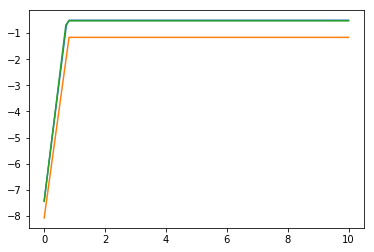

In [11]:
import matplotlib.pyplot as plt
plt.plot(t_points, [math.log(i[0]) for i in c_points])
plt.plot(t_points, [math.log(i[1]) for i in c_points])
#plt.vlines(1.6871938725761932, -9, 1, linestyles='dashed')
#plt.vlines(1.882436214937081, -9, 1, linestyles='dashed')
#plt.vlines(2.0794851804427057, -9, 1, linestyles='dashed')
plt.plot(t_points, [math.log(i[2]) for i in c_points])
#plt.plot(t_points, [math.log(i[3]) for i in c_points])

In [158]:
for i in range(37):
    system_copy, ext_list = invade(system_copy, i+83)
    if output(system_copy) != [14, 18]:
        break

In [141]:
system_copy = dilute(system_copy)
output(system_copy)

([14, 18, 82],
 [0.10126282206705466, 1.3784346120183375, 0.020304065916121893],
 [(0, 1, 2), (0, 1, 2), (2, 0, 1)],
 [array([3.66532236, 1.20289523, 2.4805498 ]),
  array([3.42109008, 3.7775886 , 2.02065415]),
  array([2.47431112, 3.08876689, 3.18287377])])

In [153]:
system_copy, ext_list = invade(system_copy, 82)
output(system_copy)[0]

[14, 18, 82]

In [12]:
for i in range(400):
    system_copy = move_to_new(system_copy)
    system_copy = dilute(system_copy)
#output(system)

In [13]:
output(system_copy)

([1, 52, 100],
 [0.6009482688446953, 0.31227396365603377, 0.5867792675007716],
 [(0, 1, 2), (1, 0, 2), (2, 1, 0)],
 [array([9.20247937, 2.12018593, 1.08945719]),
  array([2.25233966, 8.45170172, 1.88723342]),
  array([4.78820702, 1.51485071, 9.48018625])])

In [8]:
system_copy=copy.deepcopy(system)

In [155]:
system_copy = dilute(system_copy)

In [164]:
growth_rate_list

array([[1.23322145, 1.08750915, 2.79354773],
       [1.71035186, 1.30595521, 1.87276277],
       [3.08392623, 2.54891347, 2.8837156 ],
       [1.4449088 , 5.73688898, 4.32644953],
       [1.67232577, 4.66542005, 1.92361728],
       [2.02878988, 1.53232297, 4.27005929],
       [2.08170556, 3.13150986, 2.9930211 ],
       [2.3689766 , 3.45460108, 4.30973999],
       [5.83147358, 3.58749413, 1.4706877 ],
       [3.80446575, 5.02633964, 1.97526233],
       [2.64504852, 1.49183412, 2.56393551],
       [2.50739559, 1.91756216, 4.47415681],
       [5.2545394 , 3.08118328, 3.24666214],
       [4.17902999, 2.83906652, 3.79009892],
       [4.3055179 , 4.25189795, 3.74591067],
       [3.94088865, 2.09181784, 2.03755633],
       [2.14293976, 3.45342971, 2.80320241],
       [2.51865478, 4.08659253, 3.15841768],
       [2.63309594, 2.44404379, 6.40021869],
       [2.50803152, 1.81164929, 2.685497  ],
       [1.05865844, 4.0527091 , 4.7080376 ],
       [3.66498215, 4.72059556, 4.12222804],
       [3.